# NB07 — Pearson vs Spearman: Visualizing the Rank-Order Collapse

**Goal**: Make the Pearson/Spearman dissociation between fewshot and zeroshot models visually explicit.

**Context from NB05/NB06**:

| Metric | Fewshot (NB05) | Zeroshot (NB06) |
|---|---|---|
| Pearson r (Jacobian sim ~ ΔY sim) | 0.119 (p=2e-80) | 0.131 (p=5e-97) |
| Spearman r | **0.094** (p=4e-50) | **-0.003** (p=0.66, NS) |

The Pearson correlation is similar in both models — but the Spearman (rank-order) signal is present in fewshot and completely absent in zeroshot. This means the fewshot fine-tune imposes a graded, rank-order routing structure that isn't present in the backbone.

**Figures**:
- Panel A: Grouped bar chart — Pearson r and Spearman r for fewshot vs zeroshot
- Panel B/C: Rank-rank scatter — rank by ΔY similarity (x) vs rank by Jacobian similarity (y), fewshot | zeroshot
  - Fewshot should show a diagonal trend; zeroshot should be a uniform cloud


In [1]:

import subprocess

# Write the analysis + figure script
script = r"""
import numpy as np
import pandas as pd
import pickle
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

OUTDIR = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'

# ── Load fewshot (NB05) ──────────────────────────────────────────────────────
print("[1] Loading fewshot data...")
jac5 = np.load(f'{OUTDIR}/nb05_jacobians.npy')          # [225, 2000, 328]
with open(f'{OUTDIR}/nb05_jacobian_kd_names.pkl', 'rb') as f:
    kd5 = pickle.load(f)
dy5 = pd.read_parquet(f'{OUTDIR}/nb05_delta_y.parquet') # [2023, 2000]
clusters5 = pd.read_csv(f'{OUTDIR}/nb05_clusters.csv', index_col=0)
print(f"  jac5: {jac5.shape}, kd5: {len(kd5)}, dy5: {dy5.shape}")
print(f"  clusters5 columns: {list(clusters5.columns)}")

# ── Load zeroshot (NB06) ─────────────────────────────────────────────────────
print("[2] Loading zeroshot data...")
jac6 = np.load(f'{OUTDIR}/nb06_jacobians.npy')          # [225, 2000, 328]
with open(f'{OUTDIR}/nb06_jacobian_kd_names.pkl', 'rb') as f:
    kd6 = pickle.load(f)
dy6 = pd.read_parquet(f'{OUTDIR}/nb06_delta_y.parquet') # [2023, 2000]
clusters6 = pd.read_csv(f'{OUTDIR}/nb06_clusters.csv', index_col=0)
print(f"  jac6: {jac6.shape}, kd6: {len(kd6)}, dy6: {dy6.shape}")

# ── Helper: pairwise cosine sims for the rep KD set ─────────────────────────
def pairwise_sims(jac, kd_names, dy_df):
    n = len(kd_names)
    # Jacobian: flatten and cosine sim
    jac_flat = jac.reshape(n, -1).astype(np.float32)
    jac_sim = cosine_similarity(jac_flat)   # [n, n]
    # ΔY: align by KD name
    dy_vals = dy_df.loc[dy_df.index.isin(kd_names)].reindex(kd_names)
    dy_arr = dy_vals.values.astype(np.float32)
    dy_sim = cosine_similarity(dy_arr)      # [n, n]
    # Upper triangle pairs (no diagonal)
    idx = np.triu_indices(n, k=1)
    return jac_sim[idx], dy_sim[idx]

print("[3] Computing pairwise similarities...")
jac_sim5, dy_sim5 = pairwise_sims(jac5, kd5, dy5)
jac_sim6, dy_sim6 = pairwise_sims(jac6, kd6, dy6)
print(f"  Pairs: {len(jac_sim5):,}")

# ── Verify stats match summary JSONs ─────────────────────────────────────────
pr5, _ = pearsonr(jac_sim5, dy_sim5)
sr5, sp5 = spearmanr(jac_sim5, dy_sim5)
pr6, _ = pearsonr(jac_sim6, dy_sim6)
sr6, sp6 = spearmanr(jac_sim6, dy_sim6)
print(f"\n  Fewshot  — Pearson r={pr5:.4f}, Spearman r={sr5:.4f} (p={sp5:.2e})")
print(f"  Zeroshot — Pearson r={pr6:.4f}, Spearman r={sr6:.4f} (p={sp6:.2e})")

# ── Figure ───────────────────────────────────────────────────────────────────
print("[4] Building figure...")

fig = plt.figure(figsize=(14, 9))
gs = gridspec.GridSpec(2, 3, figure=fig,
                       left=0.07, right=0.97,
                       top=0.92, bottom=0.10,
                       hspace=0.38, wspace=0.35,
                       height_ratios=[1, 1.4])

# ── Panel A: bar chart ───────────────────────────────────────────────────────
ax_bar = fig.add_subplot(gs[0, :])

metrics   = ['Pearson r', 'Spearman r']
fs_vals   = [pr5, sr5]
zs_vals   = [pr6, sr6]
x = np.arange(len(metrics))
w = 0.28
colors_fs = ['#2563EB', '#2563EB']
colors_zs = ['#DC2626', '#DC2626']

bars_fs = ax_bar.bar(x - w/2, fs_vals, w, label='Fewshot/HepG2 (NB05)',
                     color='#2563EB', alpha=0.85, edgecolor='white', linewidth=0.5)
bars_zs = ax_bar.bar(x + w/2, zs_vals, w, label='Zeroshot/HepG2 (NB06)',
                     color='#DC2626', alpha=0.85, edgecolor='white', linewidth=0.5)

# Annotate bars
for bar, val in zip(bars_fs, fs_vals):
    ypos = val + 0.004 if val >= 0 else val - 0.012
    ax_bar.text(bar.get_x() + bar.get_width()/2, ypos, f'{val:.3f}',
                ha='center', va='bottom' if val >= 0 else 'top', fontsize=10,
                fontweight='bold', color='#2563EB')
for bar, val in zip(bars_zs, zs_vals):
    ypos = val + 0.004 if val >= 0 else val - 0.012
    ax_bar.text(bar.get_x() + bar.get_width()/2, ypos, f'{val:.3f}',
                ha='center', va='bottom' if val >= 0 else 'top', fontsize=10,
                fontweight='bold', color='#DC2626')

ax_bar.axhline(0, color='black', linewidth=0.8, linestyle='-')
ax_bar.set_xticks(x)
ax_bar.set_xticklabels(metrics, fontsize=12)
ax_bar.set_ylabel('Correlation (Jacobian sim ~ ΔY sim)', fontsize=11)
ax_bar.set_title('Routing Coherence: Pearson vs Spearman — Fewshot vs Zeroshot', fontsize=13, fontweight='bold')
ax_bar.legend(fontsize=10, loc='upper right')
ax_bar.set_ylim(-0.04, 0.22)
ax_bar.grid(axis='y', alpha=0.3, linewidth=0.5)
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)

# Significance annotations
ax_bar.annotate('p=4×10⁻⁵⁰', xy=(0 - w/2, sr5), xytext=(0 - w/2 - 0.32, sr5 + 0.02),
                fontsize=8, color='#2563EB',
                arrowprops=dict(arrowstyle='->', color='#2563EB', lw=0.8))
ax_bar.annotate('p=0.66 (NS)', xy=(0 + w/2, sr6), xytext=(0 + w/2 + 0.08, sr6 + 0.025),
                fontsize=8, color='#DC2626',
                arrowprops=dict(arrowstyle='->', color='#DC2626', lw=0.8))

# ── Panels B & C: rank-rank scatter ─────────────────────────────────────────
def rank_rank_scatter(ax, jac_sims, dy_sims, title, color, pr, sr):
    n_pairs = len(jac_sims)
    rank_dy  = np.argsort(np.argsort(dy_sims))   / n_pairs  # [0, 1]
    rank_jac = np.argsort(np.argsort(jac_sims))  / n_pairs

    # Hexbin for density
    hb = ax.hexbin(rank_dy, rank_jac, gridsize=60, cmap='Blues' if color == '#2563EB' else 'Reds',
                   mincnt=1, linewidths=0.1)

    ax.set_xlabel('Rank of ΔY similarity\n(low → high output similarity)', fontsize=9)
    ax.set_ylabel('Rank of Jacobian similarity\n(low → high routing similarity)', fontsize=9)
    ax.set_title(title, fontsize=11, fontweight='bold')

    # Annotate with r values
    textstr = f'Pearson r = {pr:.3f}\nSpearman r = {sr:.3f}'
    ax.text(0.04, 0.94, textstr, transform=ax.transAxes,
            fontsize=9, va='top', color=color,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.85, edgecolor=color))

    # Reference diagonal (what r=1 would look like)
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.25, lw=1, label='perfect r=1')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')

# Left: fewshot
ax_fs = fig.add_subplot(gs[1, :2])
rank_rank_scatter(ax_fs, jac_sim5, dy_sim5,
                  'Fewshot/HepG2 — rank-rank scatter\n(Spearman r=0.094: diagonal trend visible)',
                  '#2563EB', pr5, sr5)

# Right: zeroshot
ax_zs = fig.add_subplot(gs[1, 2])
rank_rank_scatter(ax_zs, jac_sim6, dy_sim6,
                  'Zeroshot/HepG2\n(Spearman r≈0: uniform cloud)',
                  '#DC2626', pr6, sr6)

outpath = f'{OUTDIR}/nb07_pearson_vs_spearman.png'
fig.savefig(outpath, dpi=150, bbox_inches='tight')
print(f"\nSaved: {outpath}")
"""

with open('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb07_run.py', 'w') as f:
    f.write(script)
print("Script written.")


Script written.


In [2]:

import subprocess

result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb07_run.py'],
    capture_output=True, text=True, timeout=300
)
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr[-2000:])
print("Return code:", result.returncode)


[1] Loading fewshot data...
  jac5: (225, 2000, 328), kd5: 225, dy5: (2023, 2000)
  clusters5 columns: ['cluster']
[2] Loading zeroshot data...
  jac6: (225, 2000, 328), kd6: 225, dy6: (2023, 2000)
[3] Computing pairwise similarities...
  Pairs: 25,200

  Fewshot  — Pearson r=0.1192, Spearman r=0.0936 (p=3.83e-50)
  Zeroshot — Pearson r=0.1311, Spearman r=-0.0028 (p=6.59e-01)
[4] Building figure...

Saved: /mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb07_pearson_vs_spearman.png

Return code: 0


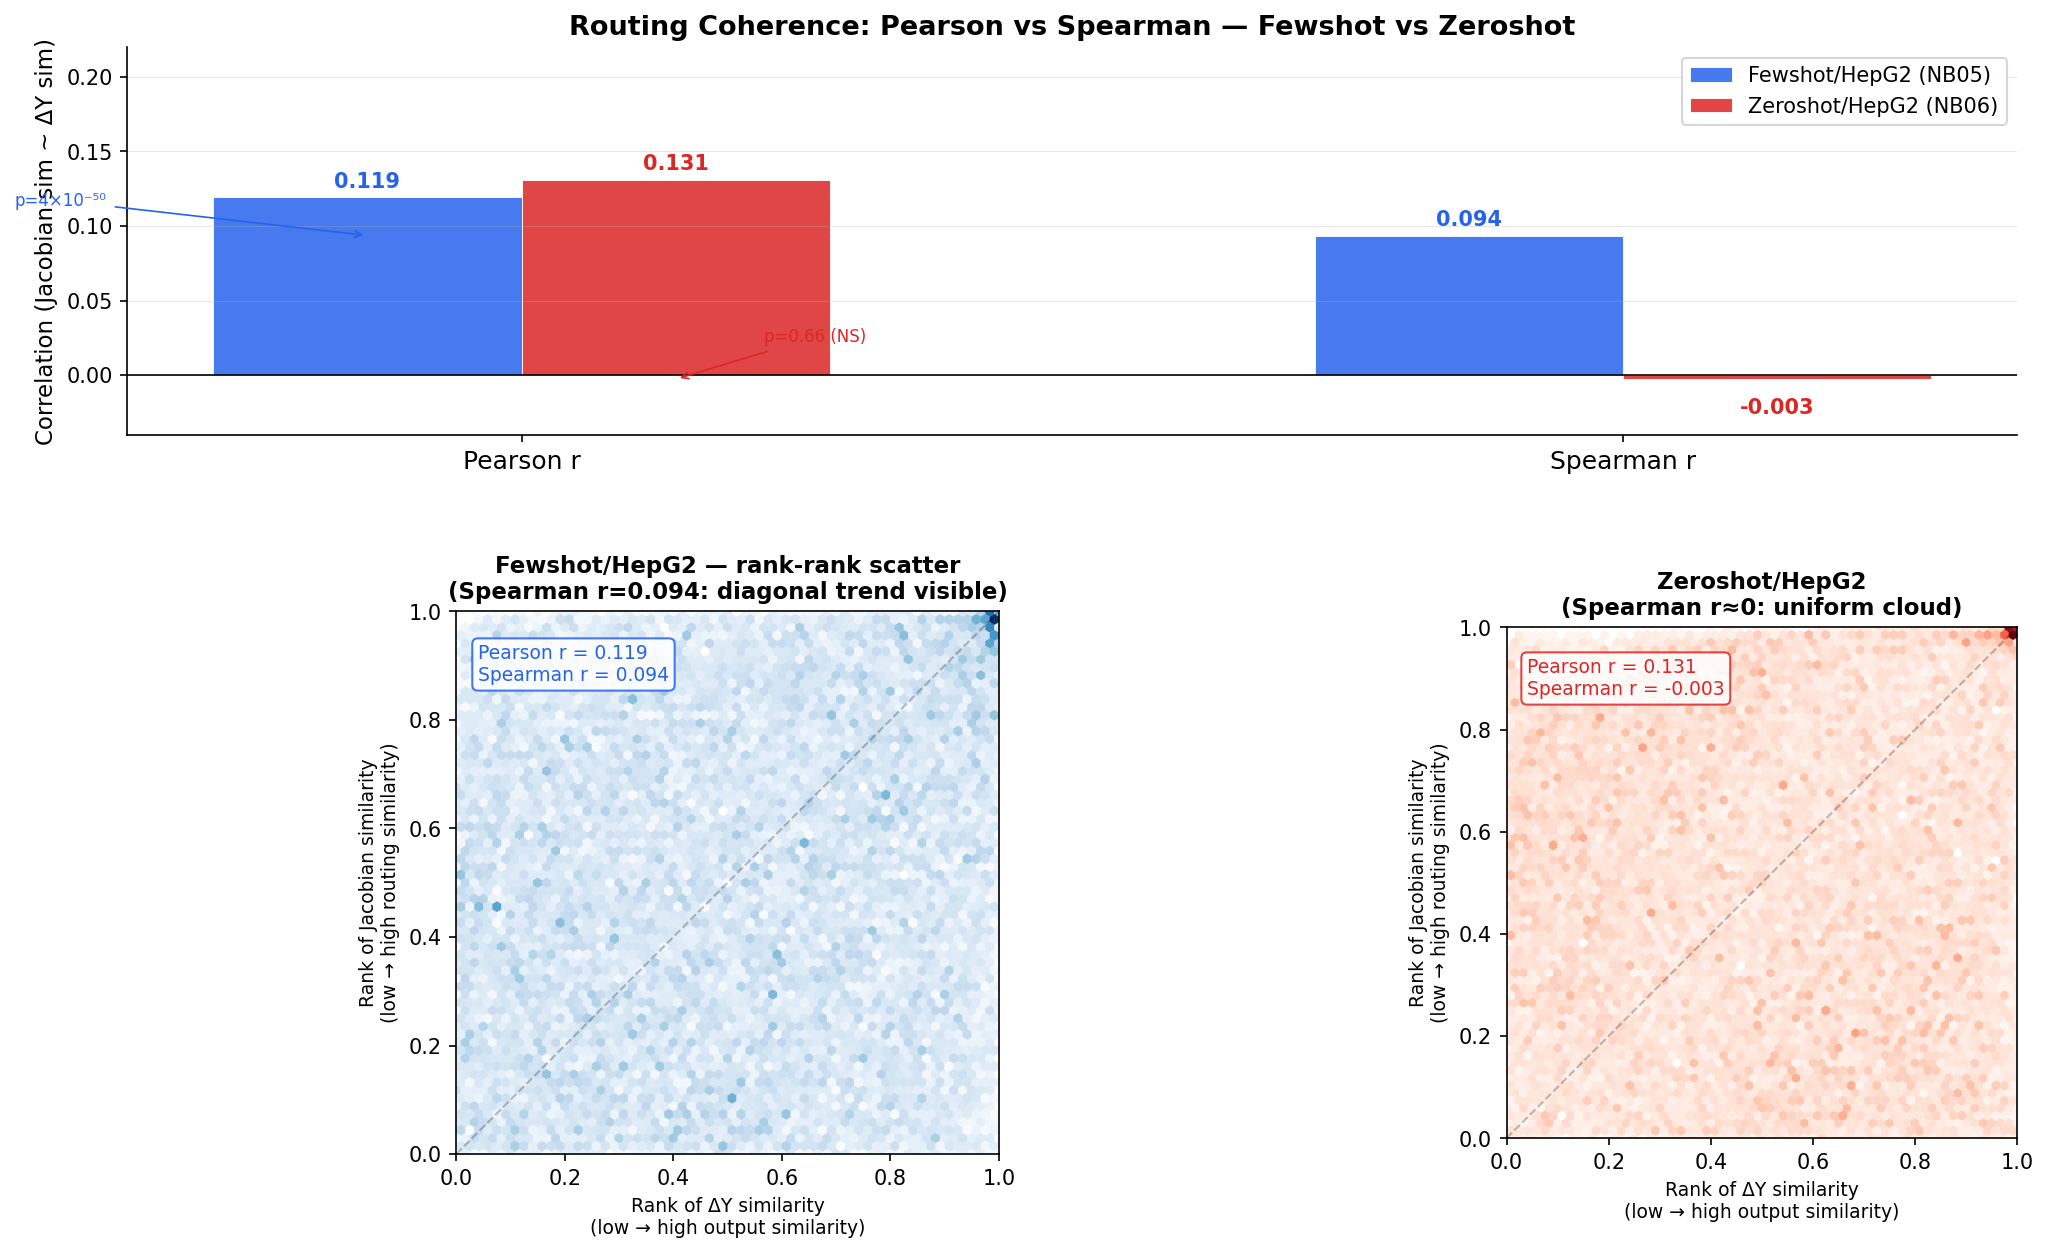

In [3]:

from IPython.display import Image, display
display(Image(filename='/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb07_pearson_vs_spearman.png', width=1100))


In [4]:

import shutil
src = '/mnt/polished-lake/home/mbeheleramass/notebooks/2026-02-27-16-52_nb07_spearman_visualization.ipynb'
dst = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb07_spearman_visualization.ipynb'
shutil.copy2(src, dst)
print(f"Saved to: {dst}")


Saved to: /mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb07_spearman_visualization.ipynb


In [5]:

script = r"""
import numpy as np
import pandas as pd
import pickle
from scipy.stats import pearsonr, spearmanr, sem
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

OUTDIR = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'

# ── Load data ────────────────────────────────────────────────────────────────
jac5 = np.load(f'{OUTDIR}/nb05_jacobians.npy')
with open(f'{OUTDIR}/nb05_jacobian_kd_names.pkl', 'rb') as f:
    kd5 = pickle.load(f)
dy5 = pd.read_parquet(f'{OUTDIR}/nb05_delta_y.parquet')

jac6 = np.load(f'{OUTDIR}/nb06_jacobians.npy')
with open(f'{OUTDIR}/nb06_jacobian_kd_names.pkl', 'rb') as f:
    kd6 = pickle.load(f)
dy6 = pd.read_parquet(f'{OUTDIR}/nb06_delta_y.parquet')

def pairwise_sims(jac, kd_names, dy_df):
    n = len(kd_names)
    jac_flat = jac.reshape(n, -1).astype(np.float32)
    jac_sim  = cosine_similarity(jac_flat)
    dy_vals  = dy_df.reindex(kd_names).values.astype(np.float32)
    dy_sim   = cosine_similarity(dy_vals)
    idx = np.triu_indices(n, k=1)
    return jac_sim[idx], dy_sim[idx]

jac_sim5, dy_sim5 = pairwise_sims(jac5, kd5, dy5)
jac_sim6, dy_sim6 = pairwise_sims(jac6, kd6, dy6)

pr5, _ = pearsonr(jac_sim5, dy_sim5)
sr5, sp5 = spearmanr(jac_sim5, dy_sim5)
pr6, _ = pearsonr(jac_sim6, dy_sim6)
sr6, sp6 = spearmanr(jac_sim6, dy_sim6)
print(f"Fewshot  Pearson={pr5:.4f} Spearman={sr5:.4f} (p={sp5:.2e})")
print(f"Zeroshot Pearson={pr6:.4f} Spearman={sr6:.4f} (p={sp6:.2e})")

# ── Decile binning ───────────────────────────────────────────────────────────
N_BINS = 10

def decile_means(dy_sims, jac_sims, n_bins=N_BINS):
    """Bin pairs by ΔY similarity decile, return (bin_centres, mean_jac_rank, se)."""
    # Convert Jacobian sims to ranks (normalised 0-1)
    rank_jac = np.argsort(np.argsort(jac_sims)) / len(jac_sims)
    # Assign each pair to a ΔY decile bin
    bins = np.percentile(dy_sims, np.linspace(0, 100, n_bins + 1))
    bins[-1] += 1e-9  # make last bin inclusive
    labels = np.digitize(dy_sims, bins) - 1
    labels = np.clip(labels, 0, n_bins - 1)
    centres, means, errors = [], [], []
    for b in range(n_bins):
        mask = labels == b
        vals = rank_jac[mask]
        centres.append(dy_sims[mask].mean())
        means.append(vals.mean())
        errors.append(sem(vals))
    return np.array(centres), np.array(means), np.array(errors)

c5, m5, e5 = decile_means(dy_sim5, jac_sim5)
c6, m6, e6 = decile_means(dy_sim6, jac_sim6)

# ── Figure ───────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(13, 5.5))
fig.suptitle('Routing Coherence: Pearson vs Spearman — Fewshot vs Zeroshot',
             fontsize=13, fontweight='bold', y=1.01)

COL_FS = '#2563EB'
COL_ZS = '#DC2626'

# ── Panel A: grouped bar chart ───────────────────────────────────────────────
ax = axes[0]
x = np.array([0, 1])
w = 0.3
b1 = ax.bar(x - w/2, [pr5, sr5], w, color=COL_FS, alpha=0.85, label='Fewshot/HepG2 (NB05)')
b2 = ax.bar(x + w/2, [pr6, sr6], w, color=COL_ZS, alpha=0.85, label='Zeroshot/HepG2 (NB06)')

for bar, val, col in zip(list(b1)+list(b2), [pr5,sr5,pr6,sr6], [COL_FS,COL_FS,COL_ZS,COL_ZS]):
    offset = 0.005 if val >= 0 else -0.005
    va = 'bottom' if val >= 0 else 'top'
    ax.text(bar.get_x() + bar.get_width()/2, val + offset,
            f'{val:.3f}', ha='center', va=va, fontsize=10,
            fontweight='bold', color=col)

# p-value callouts
ax.annotate('p = 4×10⁻⁵⁰', xy=(0.5 + w/2, sr5), xytext=(0.5 + w/2 + 0.25, sr5 + 0.025),
            fontsize=8.5, color=COL_FS,
            arrowprops=dict(arrowstyle='->', color=COL_FS, lw=0.8))
ax.annotate('p = 0.66 (NS)', xy=(0.5 + w/2, sr6 - 0.001), xytext=(0.5 + w/2 + 0.25, sr6 - 0.025),
            fontsize=8.5, color=COL_ZS,
            arrowprops=dict(arrowstyle='->', color=COL_ZS, lw=0.8))

ax.axhline(0, color='black', lw=0.8)
ax.set_xticks(x)
ax.set_xticklabels(['Pearson r', 'Spearman r'], fontsize=12)
ax.set_ylabel('Correlation\n(Jacobian similarity ~ ΔY similarity)', fontsize=10)
ax.set_ylim(-0.04, 0.21)
ax.legend(fontsize=9, loc='upper left')
ax.grid(axis='y', alpha=0.3, lw=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('A  Summary statistics', fontsize=11, loc='left', fontweight='bold')

# ── Panel B: decile line plot ────────────────────────────────────────────────
ax2 = axes[1]

ax2.errorbar(c5, m5, yerr=e5, color=COL_FS, marker='o', ms=6, lw=2,
             capsize=3, label=f'Fewshot (Spearman r={sr5:.3f}, p=4×10⁻⁵⁰)', zorder=3)
ax2.errorbar(c6, m6, yerr=e6, color=COL_ZS, marker='s', ms=6, lw=2,
             capsize=3, label=f'Zeroshot (Spearman r={sr6:.3f}, NS)', zorder=3)

ax2.axhline(0.5, color='gray', lw=1, linestyle='--', alpha=0.5, label='Expected if no correlation')

ax2.set_xlabel('ΔY cosine similarity\n(binned into deciles, low → high output similarity)', fontsize=10)
ax2.set_ylabel('Mean rank of Jacobian similarity\n(normalised 0–1, mean ± SE)', fontsize=10)
ax2.set_title('B  Decile-binned mean Jacobian rank', fontsize=11, loc='left', fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3, lw=0.5)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
outpath = f'{OUTDIR}/nb07_pearson_vs_spearman.png'
fig.savefig(outpath, dpi=150, bbox_inches='tight')
print(f"Saved: {outpath}")
"""

with open('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb07_run.py', 'w') as f:
    f.write(script)

import subprocess
result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb07_run.py'],
    capture_output=True, text=True, timeout=300
)
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr[-2000:])
print("Return code:", result.returncode)


SyntaxError: invalid syntax (1047743890.py, line 48)

In [6]:

nb07_script = """
import numpy as np
import pandas as pd
import pickle
from scipy.stats import pearsonr, spearmanr, sem
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

OUTDIR = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'

jac5 = np.load(f'{OUTDIR}/nb05_jacobians.npy')
with open(f'{OUTDIR}/nb05_jacobian_kd_names.pkl', 'rb') as f:
    kd5 = pickle.load(f)
dy5 = pd.read_parquet(f'{OUTDIR}/nb05_delta_y.parquet')

jac6 = np.load(f'{OUTDIR}/nb06_jacobians.npy')
with open(f'{OUTDIR}/nb06_jacobian_kd_names.pkl', 'rb') as f:
    kd6 = pickle.load(f)
dy6 = pd.read_parquet(f'{OUTDIR}/nb06_delta_y.parquet')

def pairwise_sims(jac, kd_names, dy_df):
    n = len(kd_names)
    jac_flat = jac.reshape(n, -1).astype(np.float32)
    jac_sim  = cosine_similarity(jac_flat)
    dy_vals  = dy_df.reindex(kd_names).values.astype(np.float32)
    dy_sim   = cosine_similarity(dy_vals)
    idx = np.triu_indices(n, k=1)
    return jac_sim[idx], dy_sim[idx]

jac_sim5, dy_sim5 = pairwise_sims(jac5, kd5, dy5)
jac_sim6, dy_sim6 = pairwise_sims(jac6, kd6, dy6)

pr5, _ = pearsonr(jac_sim5, dy_sim5)
sr5, sp5 = spearmanr(jac_sim5, dy_sim5)
pr6, _ = pearsonr(jac_sim6, dy_sim6)
sr6, sp6 = spearmanr(jac_sim6, dy_sim6)
print(f"Fewshot  Pearson={pr5:.4f} Spearman={sr5:.4f}")
print(f"Zeroshot Pearson={pr6:.4f} Spearman={sr6:.4f}")

N_BINS = 10

def decile_means(dy_sims, jac_sims, n_bins=N_BINS):
    rank_jac  = np.argsort(np.argsort(jac_sims)) / len(jac_sims)
    bin_edges = np.percentile(dy_sims, np.linspace(0, 100, n_bins + 1))
    bin_edges[-1] += 1e-9
    labels = np.clip(np.digitize(dy_sims, bin_edges) - 1, 0, n_bins - 1)
    centres, means, errors = [], [], []
    for b in range(n_bins):
        mask = labels == b
        vals = rank_jac[mask]
        centres.append(dy_sims[mask].mean())
        means.append(vals.mean())
        errors.append(sem(vals))
    return np.array(centres), np.array(means), np.array(errors)

c5, m5, e5 = decile_means(dy_sim5, jac_sim5)
c6, m6, e6 = decile_means(dy_sim6, jac_sim6)

COL_FS = '#2563EB'
COL_ZS = '#DC2626'

fig, axes = plt.subplots(1, 2, figsize=(13, 5.5))
fig.suptitle('Routing Coherence: Pearson vs Spearman  —  Fewshot vs Zeroshot',
             fontsize=13, fontweight='bold', y=1.01)

# Panel A: bar chart
ax = axes[0]
x = np.array([0, 1])
w = 0.3
b1 = ax.bar(x - w/2, [pr5, sr5], w, color=COL_FS, alpha=0.85, label='Fewshot/HepG2 (NB05)')
b2 = ax.bar(x + w/2, [pr6, sr6], w, color=COL_ZS, alpha=0.85, label='Zeroshot/HepG2 (NB06)')
for bar, val, col in zip(list(b1)+list(b2), [pr5, sr5, pr6, sr6],
                         [COL_FS, COL_FS, COL_ZS, COL_ZS]):
    offset = 0.005 if val >= 0 else -0.005
    va = 'bottom' if val >= 0 else 'top'
    ax.text(bar.get_x() + bar.get_width()/2, val + offset, f'{val:.3f}',
            ha='center', va=va, fontsize=10, fontweight='bold', color=col)
ax.annotate('p = 4e-50', xy=(x[1] - w/2, sr5), xytext=(x[1] + 0.05, sr5 + 0.03),
            fontsize=8.5, color=COL_FS, arrowprops=dict(arrowstyle='->', color=COL_FS, lw=0.8))
ax.annotate('p = 0.66 (NS)', xy=(x[1] + w/2, sr6), xytext=(x[1] + 0.3, sr6 - 0.03),
            fontsize=8.5, color=COL_ZS, arrowprops=dict(arrowstyle='->', color=COL_ZS, lw=0.8))
ax.axhline(0, color='black', lw=0.8)
ax.set_xticks(x)
ax.set_xticklabels(['Pearson r', 'Spearman r'], fontsize=12)
ax.set_ylabel('Correlation (Jacobian sim ~ ΔY sim)', fontsize=10)
ax.set_ylim(-0.05, 0.22)
ax.legend(fontsize=9, loc='upper left')
ax.grid(axis='y', alpha=0.3, lw=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('A   Summary statistics', fontsize=11, loc='left', fontweight='bold')

# Panel B: decile line plot
ax2 = axes[1]
ax2.errorbar(c5, m5, yerr=e5, color=COL_FS, marker='o', ms=6, lw=2, capsize=3,
             label=f'Fewshot   Spearman r = {sr5:.3f} (p=4e-50)', zorder=3)
ax2.errorbar(c6, m6, yerr=e6, color=COL_ZS, marker='s', ms=6, lw=2, capsize=3,
             label=f'Zeroshot  Spearman r = {sr6:.3f} (NS)', zorder=3)
ax2.axhline(0.5, color='gray', lw=1.2, linestyle='--', alpha=0.6, label='Flat (no correlation)')
ax2.set_xlabel('ΔY cosine similarity (binned into deciles)', fontsize=10)
ax2.set_ylabel('Mean rank of Jacobian similarity\\n(normalised 0-1, mean +/- SE per bin)', fontsize=10)
ax2.set_title('B   Decile-binned mean Jacobian rank', fontsize=11, loc='left', fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3, lw=0.5)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
outpath = f'{OUTDIR}/nb07_pearson_vs_spearman.png'
fig.savefig(outpath, dpi=150, bbox_inches='tight')
print(f"Saved: {outpath}")
"""

with open('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb07_run.py', 'w') as fh:
    fh.write(nb07_script)
print("Written.")


Written.


In [7]:

import subprocess

result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb07_run.py'],
    capture_output=True, text=True, timeout=300
)
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr[-2000:])
print("Return code:", result.returncode)


Fewshot  Pearson=0.1192 Spearman=0.0936
Zeroshot Pearson=0.1311 Spearman=-0.0028
Saved: /mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb07_pearson_vs_spearman.png

Return code: 0


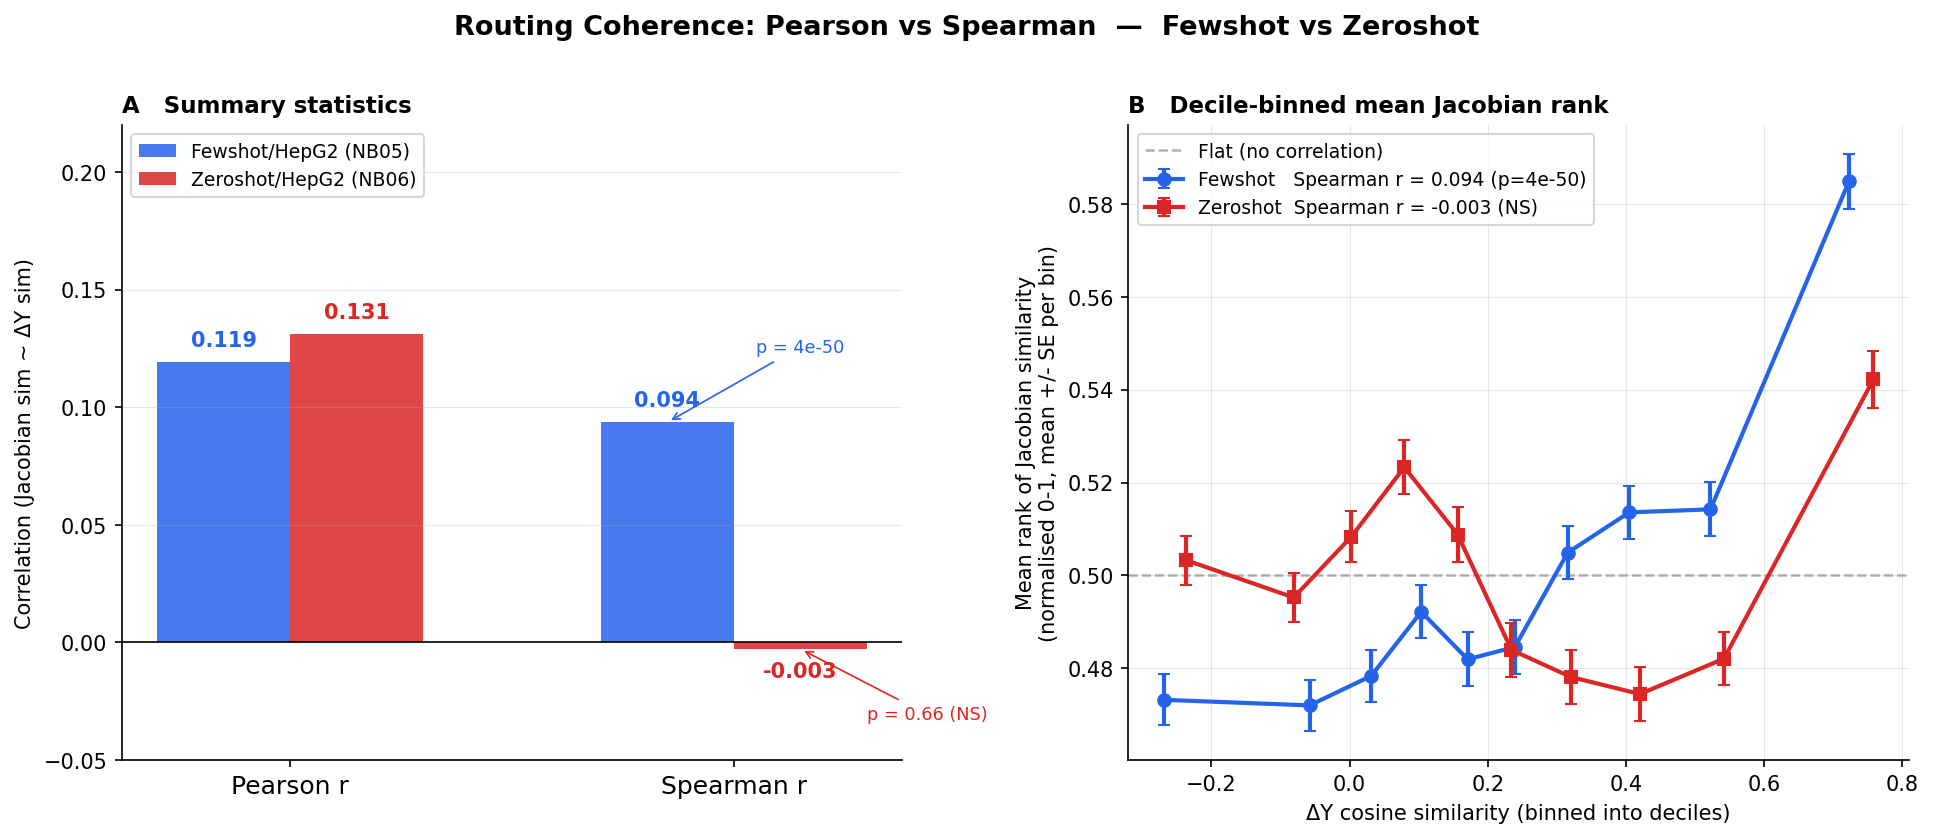

In [8]:

from IPython.display import Image, display
display(Image(filename='/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb07_pearson_vs_spearman.png', width=1100))


In [9]:

import shutil
src = '/mnt/polished-lake/home/mbeheleramass/notebooks/2026-02-27-16-52_nb07_spearman_visualization.ipynb'
dst = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb07_spearman_visualization.ipynb'
shutil.copy2(src, dst)
print(f"Saved: {dst}")
